In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
import sys

from astropy import units as u
from poliastro.bodies import Earth, Sun
from poliastro.twobody import Orbit
from astropy.coordinates import SkyCoord
from astropy.coordinates import GCRS
from astropy.coordinates import ICRS
from astropy.coordinates import get_moon
from astropy.time import Time
from datetime import datetime

import astropy
import PIL.Image
from astropy.utils.data import get_pkg_data_filename

#to load wcs:
#import cairo

In [8]:
#data
all_files = !ls ../Data_CometHolmes
jpeg_files = all_files[0::2] #to get only the jpeg files
#getting the image numbers

image_number = []
#for i in jpeg_files:
for i in range(len(jpeg_files)):
    image_number.append(jpeg_files[i][7:11])

In [10]:
#getting the exif
import PIL.Image
img = []
exif_data = []
n=0
for i in range(len(jpeg_files)):#len(jpeg_files)):
    image_temp = PIL.Image.open('../Data_CometHolmes/' + jpeg_files[i])
    img.append(image_temp)
    exif_data.append(img[i].getexif())
    image_temp.close()

pic_date_time = []
# associate picture number with time 
for i in range(len(jpeg_files)):#1299):
    pic_date_time.append([image_number[i], exif_data[i].get(306)])

#get only the ones with EXIF values
pdt_exif = [row for row in pic_date_time if row[1] != None ]

#some entries have the form: '2007:10:30 14:29:03\x00', so let's remove the weird ending
for i in range(len(pdt_exif)):
    if len(pdt_exif[i][1]) == 20:
        pdt_exif[i][1] = pdt_exif[i][1][:-1]

#discrepency between paper and code: we have 11 more timestamped images !!!!

In [11]:

#woups! we need JD date!!!
#we need the following format: '2010-01-01T00:00:00'

#getting the format
dates = np.transpose(pdt_exif)[1]
print(datetime.strptime(dates[1], "%Y:%m:%d  %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%S"))

m = len(pdt_exif)
pdt_julian = pdt_exif

for i in range(m):
    date_time_string = pdt_exif[i][1]
    #right format
    d = datetime.strptime(date_time_string, "%Y:%m:%d  %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%S")
    pdt_julian[i][1] = d
pdt_julian

2007-11-06T19:02:26


[['0001', '2007-11-01T21:44:30'],
 ['0003', '2007-11-06T19:02:26'],
 ['0004', '2007-11-08T00:37:30'],
 ['0010', '2007-11-06T23:49:01'],
 ['0011', '2007-11-06T23:49:01'],
 ['0042', '2007-11-04T17:04:49'],
 ['0064', '2007-11-05T18:16:11'],
 ['0074', '2007-11-06T17:30:57'],
 ['0078', '2007-10-24T23:56:47'],
 ['0106', '2007-10-31T10:32:19'],
 ['0127', '2007-10-28T10:03:53'],
 ['0139', '2007-11-20T13:10:51'],
 ['0215', '2007-12-18T02:45:32'],
 ['0219', '2007-11-02T19:14:37'],
 ['0270', '2007-12-08T17:36:17'],
 ['0274', '2007-11-24T19:57:20'],
 ['0276', '2007-10-28T16:32:09'],
 ['0279', '2007-11-22T17:50:30'],
 ['0280', '2007-11-22T16:04:39'],
 ['0281', '2007-11-24T19:56:54'],
 ['0282', '2007-11-22T10:39:20'],
 ['0283', '2007-11-24T22:15:59'],
 ['0284', '2007-11-07T09:36:44'],
 ['0285', '2007-11-24T19:56:18'],
 ['0286', '2007-11-17T09:55:03'],
 ['0302', '2007-10-30T14:29:03'],
 ['0303', '2007-10-30T14:28:47'],
 ['0307', '2007-11-02T11:43:37'],
 ['0308', '2007-11-02T11:43:51'],
 ['0314', '200

In [12]:
#get julian times
times = np.transpose(pdt_julian)[1]
t = Time(times, format='isot', scale='utc').jd

In [13]:
def date2julian(date_string):
    date = datetime.strptime(date_string, "%Y:%m:%d  %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%S")
    julian = Time(date, format='isot', scale='utc').jd
    return julian

t_min = date2julian("2007:07:02  00:00:00") #july 1st 2007
t_max = date2julian("2008:05:01  00:00:00") #may 1st 2008
print(t_min, t_max)


2454283.5 2454587.5


delta time: 304.0 , # bins: 38 38.0


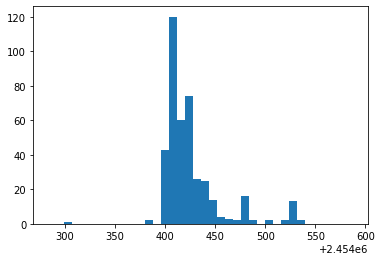

In [14]:
delta_t = t_max-t_min
bins_width = 8.0 #number of days in JD is just the number of days
bins_num = int(delta_t/bins_width) #integer

print('delta time:', delta_t, ', # bins:', bins_num,delta_t/bins_width)

#keep only times between t_min and t_max
#times_filtered = [i for i in t if not  i <= t_min and i <= t_max] 
hist_array, hist_bins, hist_patches = plt.hist(t, bins = bins_num, range = (t_min, t_max));


In [15]:
extra_counts = np.linspace(t_min + 4.0, t_max + 4.0, 39)

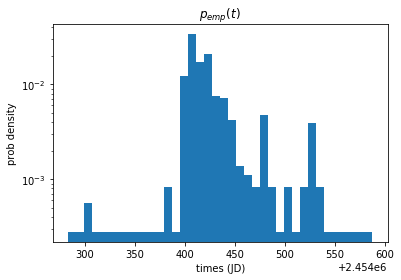

In [16]:
plt.title('$p_{emp}(t)$')
plt.xlabel('times (JD)')
plt.ylabel('prob density')
plt.semilogy()
prob_time, bins_norm, patches_norm = plt.hist(np.concatenate((t, extra_counts)), bins = bins_num, range = (t_min, t_max), density = True)


In [17]:
#function that takes the position and velocity vectors at a certain epoch and returns the ICRS coordinates of the
#object over a time grid (these are approximately ICRS, but the orbit is really around the CM of the sun and
#not the solar system barycenter)
#r and v are three element lists that represent vectors and need to have the proper units appended
#2454416 = November 12th 2007

def orbit_sim(r, v,  n_points, t_i, t_f, epoch = 2454416):
    #making a list of times to sample:
    times = np.linspace(t_i, t_f, n_points)
    
    #making the propagation delta
    prop_delta = [(i - epoch)*u.day for i in times]
    
    #defining orbit object
    orbit = Orbit.from_vectors(Sun, r, v)
    
    #initialize array to store the positions
    locations = [0 for i in range(n_points)]
    
    #looping over linspace to evaluate the orbit at all of these points
    for i in range(len(prop_delta)):
        locations[i] = orbit.propagate(prop_delta[i]).rv()[0]
    
    return [locations, times]

In [18]:
#function that takes the cartesian (x,y,z) in ICRS frame and returns the ra and dec as seen from the earth
def ICRS_to_GCRS(positions, times):
    
    coords = [0 for i in range(len(times))]
    
    
    for i in range(len(positions)):
        temp_time = Time(times[i], format='jd')
        X,Y,Z = positions[i].value
        temp_coord = SkyCoord(x = X, y = Y, z = Z, unit='km' ,frame = 'icrs' , representation_type = 'cartesian', obstime=temp_time)
        coords[i] = temp_coord.transform_to('gcrs')
        
    return coords
        

In [19]:
simulated = orbit_sim([10**8,10**8,10**8]*u.km, [0,0,5]*u.km/u.s, 20, 2454283.5, 2454587.5, 2454416)
ICRS_to_GCRS(simulated[0], simulated[1])[3].ra.degree

131.65963509432217

In [20]:
#takes a plt.imread image, WCS object from .wcs file, eta (0,1), and point is a SkyCoord object
#determines if point is in the eta subimage of the image as defined in the paper

def subimage_contains(img, wcs_func, eta, point):
    
    #assigning variables to the image dimensions
    a,b = img.shape[:2]
    
    #variable assignments that have to do with determining whether the point is in the eta subimage
    r_eta = np.sqrt(eta)
    am = int(a*(1-r_eta)/2)
    ap = int(a*(1+r_eta)/2)
    bm = int(b*(1-r_eta)/2)
    bp = int(b*(1+r_eta)/2)
    
    #boolean values 
    Abool = point.contained_by(wcs_func, image = np.ones((b,am)))
    Bbool = point.contained_by(wcs_func, image = np.ones((bm,a)))
    Cbool = point.contained_by(wcs_func, image = np.ones((bp,ap)))
    
    #boolshit
    final_bool = (not Abool) and (not Bbool) and (Cbool)
    
    return final_bool

def subimage_contains_test(ra_dec_info, eta, point):
    ra_center, ra_min, ra_max, dec_center, dec_min, dec_max =  ra_dec_info
    ra_point = point.ra.degree
    dec_point = point.dec.degree
    
    new_dec_max = dec_center + (dec_max-dec_min)*np.sqrt(eta)/2
    new_dec_min = dec_center - (dec_max-dec_min)*np.sqrt(eta)/2
    
    new_ra_max = ra_center + (ra_max-ra_min)*np.sqrt(eta)/2
    new_ra_min = ra_center - (ra_max-ra_min)*np.sqrt(eta)/2

    if new_ra_min <= ra_point <= new_ra_max and new_dec_min <= dec_point <= new_dec_max:
        return True
    
    return False
    

In [21]:
# takes an image (from plt.imread) with its corresponding wcs file, then computes the trajectory of the comet
# as seen from Earth and determines whether the comet can be found in a subimage 
def find_comet(r, v, eta, n_points, img, wcs_info, t_i, t_f, sky_coords): #sky coords: result of ICRS_to_GCRS(orbit_sim)
    
    a = wcs_info
    ra_dec_info = np.array([float(a[18][10:]),float(a[38][6:]),float(a[39][6:]),float(a[19][10:]),float(a[36][7:]), float(a[37][7:])])
    #determine whether the comet can be found in a subimage for each image
    bool_comet = [False for i in range(len(sky_coords))]
    for i in range(len(sky_coords)):
        bool_comet[i] = subimage_contains_test(ra_dec_info, eta, sky_coords[i])
        
    return bool_comet


In [22]:
test_image = plt.imread('../Data_CometHolmes/holmes-0001.jpg')
test_wcs = wcs.WCS('../Data_CometHolmes/holmes-0001.wcs')

In [23]:
#takes in r,v,eta,n params and the image's wcs to compute p_fg (eq.3) 
def p_fg(r, v, eta, n_points, img, wcs_func, wcs_info, t_i, t_f, sky_coords):
    
    #solid angle
    field_area = float(wcs_info[32][10:])
    solid_angle = field_area*(np.pi/(60*180))**2 #converting degs^2 to solid angle (sr)
    
    #determine whether a sub image contains the comet    
    comet_bool = find_comet(r, v, eta, n_points, img, wcs_info, t_i, t_f, sky_coords)
    comet_int = np.array([int(i) for i in comet_bool])
    
    return comet_int/(solid_angle*eta) 
#eq 4
def p_bg(n_points):
    return np.ones((n_points))/(4*np.pi)

In [17]:
#how to get wcs info
#a = !/Users/anahoban/software/astrometry/bin/wcsinfo ../Data_CometHolmes/holmes-0001.wcs


In [24]:
#function that evaluates eq. 2 using p_fg and p_bg
def tdep_sim_likelihood(r, v, eta, n_points, img, wcs_func, wcs_info, p_good, t_i, t_f, sky_coords):
    p_f = p_fg(r, v, eta, n_points, img, wcs_func, wcs_info, t_i, t_f, sky_coords)
    p_b = p_bg(n_points)
    
    return p_good*p_f + (1 - p_good)*p_b

In [25]:
def p_emp(time, bins_norm):
    '''Takes time and returns probability of getting that time based on time hist'''
    if bins_norm[0] > time or time > bins_norm[len(bins_norm)-1]:
            return 'Given date is not between July 1st 2007 and May 1st 2008.'
    else:
            for i in range(len(bins_norm)-1):
                if bins_norm[i] <= time and time <= bins_norm[i+1]:
                    return prob_time[i]  


def t_prior(number, time, p_exif, pdt_exif, pdt_julian, bins_norm):
    '''Takes an image and checks whether or not it has a EXIF and gives prior depending on that time (array)'''
    pdt_transpose = np.transpose(pdt_julian)
    dates_list = pdt_transpose[0].tolist()
    
    #if it has EXIF date:
    if number in np.transpose(pdt_exif):
        #get its EXIF date:
        index = dates_list.index(number)
        
        #date in JD:
        exif_date = Time(pdt_transpose[1][index], format='isot', scale='utc').jd
        
        prob = []
        for t in time:
            prob.append(p_exif * uniform_t(exif_date, t) + (1-p_exif)*p_emp(t,bins_norm))
        return np.array(prob)
        
        
    #if it doesn't have an EXIF date
    else:
        prob = []
        for t in time:
            prob.append(p_emp(t, bins_norm))
        return np.array(prob)
    
def uniform_t(t_exif, time):
    '''uniform distribution of t_i w.r.t t_exif +- 0.5 days. All times and in JD'''
    if t_exif - 0.5 <= time and time <= t_exif + 0.5:
        return 1 
    else:
        return 0
    

In [26]:
def single_im_likelihood(number, p_exif, pdt_exif, pdt_julian, bins_norm, r, v, eta, n_points, img, wcs_func, wcs_info, p_good, t_i , t_f, sky_coords ):
        time = np.linspace(t_i, t_f, n_points)
        integrand = t_prior(number, time, p_exif, pdt_exif, pdt_julian, bins_norm)*tdep_sim_likelihood(r, v, eta, n_points, img, wcs_func, wcs_info, p_good, t_i, t_f, sky_coords)
        
        return np.sum(integrand)*(t_f-t_i)/(n_points-1) #note: we may not need the multiplication by delta t
    

In [155]:
#loading in data 
wcs_list = [wcs.WCS('../Data_CometHolmes/holmes-%s.wcs'%(i)) for i in image_number]
img_list = [plt.imread('../Data_CometHolmes/holmes-%s.jpg'%(i)) for i in image_number]
wcs_info = [1 for i in image_number]
for i in range(len(image_number)):
    #wcs_info[i] = !/Users/anahoban/software/astrometry/bin/wcsinfo ../Data_CometHolmes/holmes-{image_number[i]}.wcs
    wcs_info[i] = !/usr/local/astrometry/bin/wcsinfo ../Data_CometHolmes/holmes-{image_number[i]}.wcs


# Cell that enables a modified dataset:

In [180]:
ra_cents = []
dec_cents = []

for i in range(len(wcs_info)):
    ra_cents.append(float(wcs_info[i][18][10:]))
    dec_cents.append(float(wcs_info[i][19][11:]))

temp = [[image_number[i], ra_cents[i]] for i in range(len(image_number))]





temp.sort(key = lambda x: x[1])
sampled = []
for i in range(len(temp)):
    if i%13 == 0:
    #if i%1 == 0: #running on all data
        sampled.append(temp[i])

nums = np.transpose(sampled)[0]
len(sampled)

wcs_list_trimmed = [wcs.WCS('../Data_CometHolmes/holmes-%s.wcs'%(i)) for i in nums]
img_list_trimmed = [plt.imread('../Data_CometHolmes/holmes-%s.jpg'%(i)) for i in nums]
wcs_info_trimmed = [1 for i in nums]
for i in range(len(nums)):
    #wcs_info[i] = !/Users/anahoban/software/astrometry/bin/wcsinfo ../Data_CometHolmes/holmes-{image_number[i]}.wcs
    wcs_info_trimmed[i] = !/usr/local/astrometry/bin/wcsinfo ../Data_CometHolmes/holmes-{nums[i]}.wcs


In [43]:
number = '0002'
image = plt.imread('../Data_CometHolmes/holmes-%s.jpg'%(number))
wcs_header = wcs.WCS('../Data_CometHolmes/holmes-%s.wcs'%(number))
#a = !/Users/anahoban/software/astrometry/bin/wcsinfo ../Data_CometHolmes/holmes-{number}.wcs
a = !/usr/local/astrometry/bin/wcsinfo ../Data_CometHolmes/holmes-{number}.wcs
#single_im_likelihood(number, 0.8, pdt_exif, pdt_julian, bins_norm, [10**8,10**8,10**8]*u.km, [0,0,5]*u.km/u.s, 0.8, 30, image, wcs_header, a, 0.8, 2454283.5, 2454587.5)

print(a[18:20])
print(a[36:40])
np.array([float(a[18][10:]),float(a[38][6:]),float(a[39][6:]),float(a[19][10:]),float(a[36][7:]), float(a[37][7:])])

['ra_center 56.806960287', 'dec_center 50.6406037495']
['decmin 49.8528', 'decmax 51.4284', 'ramin 55.6391', 'ramax 57.9878']


array([56.80696029, 55.6391    , 57.9878    , 50.64060375, 49.8528    ,
       51.4284    ])

In [44]:
def all_im_log_likelihoods(number_lis, p_exif, pdt_exif, pdt_julian, bins_norm, r, v, eta, n_points, p_good, wcs_list, img_list, wcs_info, t_i , t_f):
    product_list = [0 for i in number_lis]
    
    pos,t = orbit_sim(r, v,  n_points, t_i, t_f, epoch = 2454416)
    sky_coords = ICRS_to_GCRS(pos,t)
    
    for i in range(len(number_lis)):
        image = img_list[i]
        wcs_header = wcs_list[i]
        wcs_inf = wcs_info[i]
        product_list[i] = single_im_likelihood(number_lis[i], p_exif, pdt_exif, pdt_julian, bins_norm, r, v, eta, n_points, image, wcs_header, wcs_inf, p_good, t_i, t_f, sky_coords)
    
    return np.sum(np.log(product_list))
        
    

In [24]:
%%time
harper = all_im_log_likelihoods(image_number, 0.8, pdt_exif, pdt_julian, bins_norm, [10**8, 10**8, 10**8]*u.km, [5,0,0]*u.km/u.s, 0.8, 4, 0.7, wcs_list, img_list, wcs_info)
#2 points: 1min33
#4points: 3min5


TypeError: all_im_log_likelihoods() missing 2 required positional arguments: 't_i' and 't_f'

# prior
### first, the position 3D isotropic gaussian should have mean 0, because we are working in a ref. frame in which the sun is as the center and this makes sense with the authors' suggestion of using [1 AU]^2 as the variance (we expect the comet to be at a dist. of order 1 A.U. from the sun).

suggestions for our future selves: 
1. change sigma to 2 A.U (perihelion)
2. escape velocity.. ?

In [45]:
from scipy.stats import multivariate_normal as mn

In [46]:
def beta_distribution(c, v_escape, alpha = 1, beta = 3): #v_esc is in km/s
    b = c/(v_escape**2)
    if c > v_escape**2:
        return 0
    else:
        return np.power(b, alpha-1)*np.power(1-b, beta-1)

def log_prior(r, v, p_good, p_exif, eta, v_escape):
    
    v_x,v_y,v_z = v
    dot_prod = v_x**2 + v_y**2 + v_z**2 #assign this above if statement since it is needed to decide if prior is nonzero
    
    
    if (0 < p_good < 1) and (0 < p_exif < 1) and (dot_prod < (v_escape**2)) and (0 < eta < 1) :
        
        #position prior
        x,y,z = r
        xyz = np.array([x,y,z])
        mu = np.array([0.0, 0.0, 0.0])

        sigma = np.array([1, 1, 1])*149597870.7 #variance is 1 A.U. in all 3 dir
                                            #we could change this 
        covariance = np.diag(sigma**2)

        p_pos = mn.pdf(xyz, mean=mu, cov=covariance)
    
        #velocity prior
        p_vel = beta_distribution(dot_prod, v_escape)
        
        
        return np.log(p_vel*p_pos)
    
    
    else:
        return -np.inf # log(0) = -inf
    
    
def log_post(theta, number_lis, pdt_exif, pdt_julian, bins_norm, n_points, wcs_list, img_list, wcs_info, t_i = 2454283.5, t_f = 2454587.5,  v_escape= 42.1):
    r_x, r_y, r_z, v_x, v_y, v_z, p_good, p_exif, eta =  theta #this defines order order of variables in theta
    r = [r_x, r_y, r_z]
    v = [v_x, v_y, v_z]
    
    lp = log_prior(r, v, p_good, p_exif, eta, v_escape)
    if not np.isfinite(lp):
        return -np.inf
    return lp + all_im_log_likelihoods(number_lis, p_exif, pdt_exif, pdt_julian, bins_norm, r*u.km, v*u.km/u.s, eta, n_points, p_good, wcs_list, img_list, wcs_info, t_i, t_f)



In [157]:
%%time
theta = [10e8, 10e8, 10e8, 5, 5, 0, 0.85, 0.75, 0.4]

log_post(theta, image_number, pdt_exif, pdt_julian, bins_norm, 50, wcs_list, img_list, wcs_info)

CPU times: user 12.4 s, sys: 462 ms, total: 12.9 s
Wall time: 14.7 s


-4867.395491213457

In [47]:
#initializing MCMC

exif_numbers = np.transpose(pdt_julian)[0]
exif_jd = t
median_date = np.median(exif_jd)

ra_lis = []
dec_lis = []

for i in wcs_info:
    ra_lis.append(float(i[18][10:]))
    dec_lis.append(float(i[19][11:]))


ra_median = np.median(ra_lis)
dec_median = np.median(dec_lis)

#getting wcs headers for the files that survive our cuts
# associate picture number with time 
wcs_cutter = []
for i in range(len(image_number)):
    wcs_cutter.append([image_number[i], exif_data[i].get(306), wcs_info[i]])

#get only the ones with EXIF values
wcs_clipped = [row for row in wcs_cutter if row[1] != None]
for i in range(len(wcs_clipped)):
    wcs_clipped[i][1] = float(exif_jd[i])
    wcs_clipped[i][2] = np.array([float(wcs_clipped[i][2][18][10:]), float(wcs_clipped[i][2][19][11:])])


    
#making time & ra & dec cut
time_cut_array = []
for i in wcs_clipped:
    #print((np.abs(i[1]-median_date) <= 7),(np.abs(i[2][0] - ra_median) <= 5), (np.abs(i[2][1] - dec_median) <= 5))
    #print(i[2][0] - ra_median)
    if (np.abs(i[1]-median_date) <= 7) and  (np.abs(i[2][0] - ra_median) <= 5) and (np.abs(i[2][1] - dec_median) <= 5):
        time_cut_array.append(i)
        

-0.29599804626919174 -0.0005473177461361842


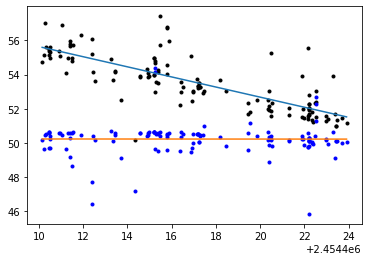

In [48]:
number, time, ra_dec = np.transpose(time_cut_array)
time = time.astype('float64')
ra = np.array([i[0] for i in ra_dec])
dec = np.array([i[1] for i in ra_dec])

a_ra, b_ra = np.polyfit(time, ra, 1)
a_dec, b_dec = np.polyfit(time, dec, 1)

plt.plot(time, ra, 'k.')
plt.plot(time, dec, 'b.')

x_axis = np.linspace(np.min(time), np.max(time), 300)

plt.plot(x_axis, x_axis*a_ra + b_ra)
plt.plot(x_axis, x_axis*a_dec + b_dec)
print(a_ra, a_dec)

In [49]:
from astropy.coordinates import CartesianDifferential

In [126]:
#our epoch is 2454416
#initializing the MCMC values

#converting our fits to km/s
proper_m_ra = a_ra*u.deg/u.day
proper_m_dec = a_dec*u.deg/u.day
initial_GCRS_pt = SkyCoord(ra = ra_median*u.deg, dec = dec_median*u.deg, distance = 1*u.au, pm_ra_cosdec = proper_m_ra, pm_dec = proper_m_dec, obstime = Time(median_date, format='jd'), frame='gcrs', radial_velocity=0*u.km/u.s)
initial_ICRS_pt = initial_GCRS_pt.transform_to('icrs')

x_init = initial_ICRS_pt.cartesian.x.to(u.km).value
y_init = initial_ICRS_pt.cartesian.y.to(u.km).value
z_init = initial_ICRS_pt.cartesian.z.to(u.km).value

v_x_init = initial_ICRS_pt.velocity.d_x.value
v_y_init = initial_ICRS_pt.velocity.d_y.value
v_z_init = initial_ICRS_pt.velocity.d_z.value


# MCMC TIME!!


In [51]:
import corner
import emcee
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'datetime', 'number']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [33]:
#number of points we are integrating over for the orbit sim
points_integration = 50

num_iter = 700
ndim = 9
nwalkers = 20
theta_init = np.array((x_init, y_init, z_init, v_x_init, v_y_init, v_z_init, 0.85, 0.75, 0.4))
initial_pos = theta_init + np.array((1500, 1500, 1500, 4.74e-5, 4.74e-5, 4.74e-5, 1e-2, 1e-2, 1e-2)) * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args = (image_number, pdt_exif, pdt_julian, bins_norm, points_integration, wcs_list, img_list, wcs_info))
sampler.run_mcmc(initial_pos, num_iter, progress=True)

100%|██████████| 700/700 [3:43:18<00:00, 19.14s/it]  


State([[ 7.50597116e+07 -4.05116591e+07  8.02438091e+07 -6.92342470e+00
   1.34621005e+01  8.69654794e+00  3.56587445e-01  6.93515097e-01
   8.67981533e-01]
 [ 7.34278235e+07 -4.26647090e+07  7.90138509e+07 -7.03383821e+00
   1.36646532e+01  8.82016890e+00  3.26014255e-01  6.36083906e-01
   8.39491911e-01]
 [ 1.30088709e+08  2.86981524e+07  2.61484683e+08 -7.01840177e+00
   1.23748630e+01  1.00990078e+01  1.75102804e-01  3.27921066e-01
   9.22462423e-01]
 [ 1.04221263e+08  1.53411250e+08  2.92670219e+08 -9.75423968e+00
   9.78352455e+00  6.51461689e+00  1.70896649e-01  4.61723606e-01
   9.86703694e-01]
 [ 5.27646432e+07 -8.30712270e+07  4.02466640e+07 -7.73333699e+00
   1.58979284e+01  1.00453857e+01  1.23972627e-01  3.76376293e-01
   8.17106551e-01]
 [ 5.73662701e+07 -8.25315588e+07  3.94081561e+07 -7.31708266e+00
   1.53481369e+01  9.77586296e+00  2.03668587e-01  5.10733661e-01
   7.68858979e-01]
 [ 5.23434494e+07  1.64084562e+08  1.44459615e+08 -1.10100594e+01
   9.12238699e+00  3.2

# Cell to use when using modified dataset

In [ ]:
#number of points we are integrating over for the orbit sim
points_integration = 30

num_iter = 700
ndim = 9
nwalkers = 20
theta_init = np.array((x_init, y_init, z_init, v_x_init, v_y_init, v_z_init, 0.85, 0.75, 0.4))
initial_pos = theta_init + np.array((1500, 1500, 1500, 4.74e-5, 4.74e-5, 4.74e-5, 1e-2, 1e-2, 1e-2)) * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args = (nums, pdt_exif, pdt_julian, bins_norm, points_integration, wcs_list_trimmed, img_list_trimmed, wcs_info_trimmed))
sampler.run_mcmc(initial_pos, num_iter, progress=True)

 30%|██▉       | 207/700 [38:49<1:37:47, 11.90s/it]

In [175]:
samples = sampler.get_chain()

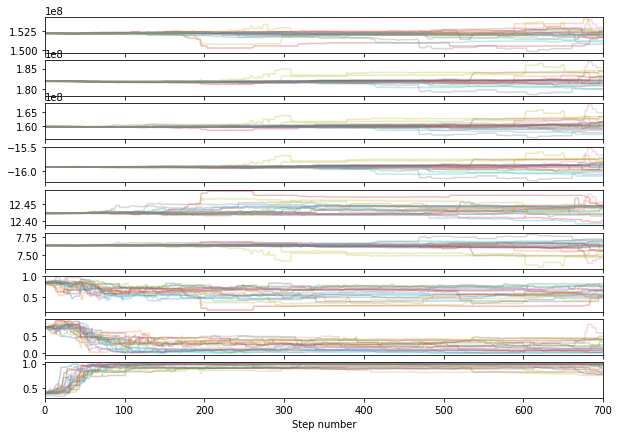

In [176]:
f, axes = plt.subplots(9, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
#labels = ["a", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
   # ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number");

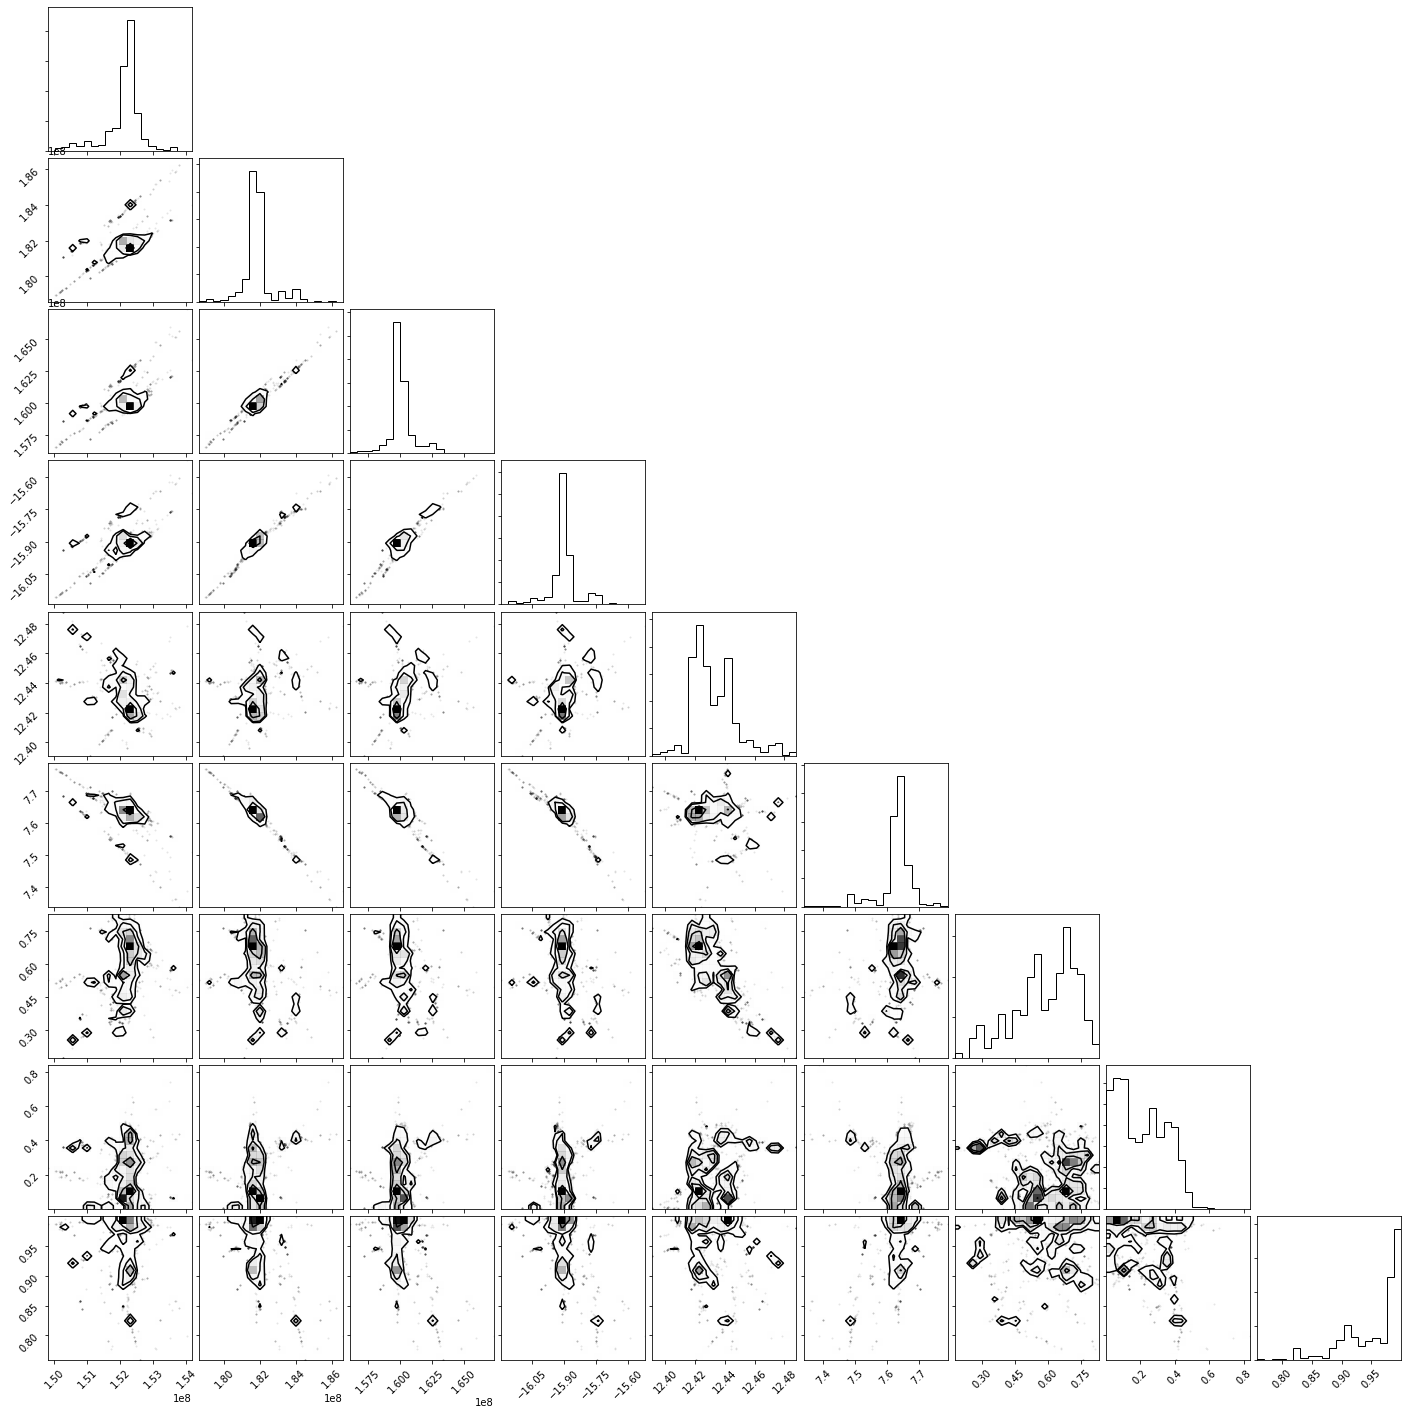

In [177]:
flat_samples = sampler.get_chain(discard=100, thin=5, flat=True)
fig = corner.corner(flat_samples);

maybe we just need to 'zoom in' on the histogram, it looks bad on this scale

In [75]:
x = np.transpose(flat_samples)[0]

(array([  3.,  26.,  91., 217., 123., 237., 237.,  84.,  10.,  21.]),
 array([7.00e+07, 7.50e+07, 8.00e+07, 8.50e+07, 9.00e+07, 9.50e+07,
        1.00e+08, 1.05e+08, 1.10e+08, 1.15e+08, 1.20e+08]),
 <a list of 10 Patch objects>)

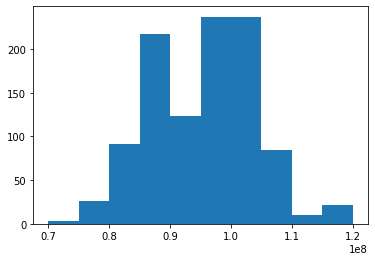

In [81]:
plt.hist(x, range = (0.7e8,1.2e8))

(array([  0.,  21.,  95., 124., 371., 265.,  64.,  98.,  11.,   1.]),
 array([-21. , -20.7, -20.4, -20.1, -19.8, -19.5, -19.2, -18.9, -18.6,
        -18.3, -18. ]),
 <a list of 10 Patch objects>)

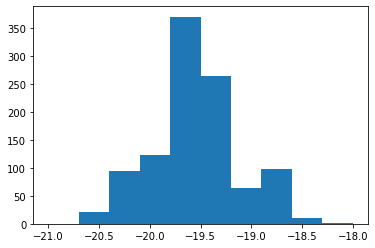

In [85]:
v_x = np.transpose(flat_samples)[3]
plt.hist(v_x, range=(-21,-18))